# Практика

In [ ]:
!pip install psycopg2

In [ ]:
import psycopg2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


DB_HOST = '89.223.95.138'
DB_USER = 'student_9'
DB_USER_PASSWORD = 'student_9'
DB_NAME = 'student_9'

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
conn = psycopg2.connect(host=DB_HOST, user=DB_USER, password=DB_USER_PASSWORD, dbname=DB_NAME)
pd.read_sql_query("""
SELECT *
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog' AND 
    schemaname != 'information_schema'
    """, conn)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,public,adv_glossary,student_9,None,True,False,True,False
1,public,adv_events,student_9,None,True,False,True,False


### Шаг 1
Сгенерируем данные по показам, кликам, и деньгам по 5 объявлениям с названиями Advertising_0, Advertising_1, ...

Просто выполните две клетки ниже

In [ ]:
adv_sample = 'Advertising_{}'
advertisings = []
for i in range(5):
  advertisings.append(adv_sample.format(i))
advertisings

['Advertising_0',
 'Advertising_1',
 'Advertising_2',
 'Advertising_3',
 'Advertising_4']

In [ ]:
from datetime import datetime, timedelta, date
DATE_FORMAT = '%Y-%m-%d'
start_date = date(2019, 8, 1)
data = {}
for adv_id in range(1, len(advertisings)+1):
  day_data = []
  data[adv_id] = []
  for idx, events_number in enumerate(np.random.random_integers(50, 100, 30)):
    events = np.zeros(events_number)
    events[np.random.rand(events_number) > 0.5] = 1
    money = np.round(events * np.random.rand(events_number)*10 + np.random.rand(events_number), 2)
    dt = start_date + timedelta(days=idx)
    dates = [dt.strftime(DATE_FORMAT) for j in range(events_number)]
    day_data = list(zip(dates, events, money))
    data[adv_id] += day_data
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(50, 100 + 1) instead
  


{1: [('2019-08-01', 1.0, 10.03),
  ('2019-08-01', 1.0, 0.49),
  ('2019-08-01', 1.0, 5.35),
  ('2019-08-01', 0.0, 0.16),
  ('2019-08-01', 1.0, 8.1),
  ('2019-08-01', 0.0, 0.33),
  ('2019-08-01', 1.0, 1.6),
  ('2019-08-01', 1.0, 8.47),
  ('2019-08-01', 0.0, 0.47),
  ('2019-08-01', 1.0, 7.65),
  ('2019-08-01', 0.0, 0.8),
  ('2019-08-01', 1.0, 9.99),
  ('2019-08-01', 0.0, 0.52),
  ('2019-08-01', 0.0, 0.59),
  ('2019-08-01', 0.0, 0.9),
  ('2019-08-01', 1.0, 8.02),
  ('2019-08-01', 1.0, 3.82),
  ('2019-08-01', 0.0, 0.94),
  ('2019-08-01', 1.0, 8.39),
  ('2019-08-01', 1.0, 6.16),
  ('2019-08-01', 0.0, 0.33),
  ('2019-08-01', 0.0, 0.41),
  ('2019-08-01', 0.0, 0.89),
  ('2019-08-01', 1.0, 10.22),
  ('2019-08-01', 0.0, 0.95),
  ('2019-08-01', 1.0, 9.19),
  ('2019-08-01', 1.0, 4.33),
  ('2019-08-01', 1.0, 10.12),
  ('2019-08-01', 0.0, 0.76),
  ('2019-08-01', 1.0, 5.91),
  ('2019-08-01', 1.0, 4.95),
  ('2019-08-01', 1.0, 3.23),
  ('2019-08-01', 0.0, 0.97),
  ('2019-08-01', 1.0, 2.57),
  ('2019-08-

In [ ]:
data.keys()

dict_keys([1, 2, 3, 4, 5])

Теперь в массиве advertisings у нас лежат названия объявлений, а в словаре data ключом является идентификатор объявления в нашей будущей базе данных (при использовании SERIAL PRIMARY KEY идентификаторы будут от 1 до 5 соответственно). 

Значениями в словаре data являются массивы tuple-ов в которых по порядку записана дата события, тип события, а также кол-во денег, которое стоило это событие. 

*   0 это показ
*   1 это клик (если был клик, то был и показ)
*   кол-во денег указано в рублях



In [ ]:
data[1][0][2]

7.49

### Шаг 2
Создадим структуру таблиц.
Нам понадобится создать две таблицы. В одной будут храниться названия объявлений с их уникальным идентификатором, а во второй будут храниться события, относящиеся к этим объявлениям. При этом вторая таблица связана с первой таблицей первичным ключом.

In [ ]:
# выполните, чтобы получить объект соединения
conn = psycopg2.connect(host=DB_HOST, user=DB_USER, password=DB_USER_PASSWORD, dbname=DB_NAME) # создаём соединение

In [ ]:
# напишите запрос для создания таблицы с объявлениями
query = """
CREATE TABLE IF NOT EXISTS adv_glossary
  (
     id   SERIAL PRIMARY KEY,
     name VARCHAR(100) NOT NULL,
     CHECK(name != '')
  ) 
"""
conn.cursor().execute(query)
conn.commit()

In [ ]:
# выполните эту клетку если захотите удалить ошибочно созданную таблицу adv_glossary
query = "DROP TABLE IF EXISTS adv_glossary"

conn.cursor().execute(query) # выполняем запрос
conn.commit() # сохраняем изменения

In [ ]:
# напишите запрос для создания таблицы с событиями по объявлениям
query = """
  CREATE TABLE IF NOT EXISTS adv_events (
    id SERIAL PRIMARY KEY,
    date DATE NOT NULL,
    event_type SMALLINT NOT NULL CHECK(event_type IN (0,1)),
    money NUMERIC(4,2) NOT NULL CHECK(money >= 0),
    adv_id INT
  )
"""
conn.cursor().execute(query)
conn.commit()

In [ ]:
# выполните эту клетку если захотите удалить ошибочно созданную таблицу adv_events
query = "DROP TABLE IF EXISTS adv_events"

conn.cursor().execute(query) # выполняем запрос
conn.commit() # сохраняем изменения

In [ ]:
conn.rollback()

In [ ]:
# а также добавьте ограничение целостности на идентификатор объявления
query = """ 
        ALTER TABLE adv_events 
              ADD FOREIGN KEY(adv_id) 
              REFERENCES adv_glossary(id)
        """
conn.cursor().execute(query)
conn.commit()

In [ ]:
pd.read_sql_query("""
SELECT *
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog' AND 
    schemaname != 'information_schema'
    """, conn)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,public,adv_glossary,student_9,None,True,False,True,False
1,public,adv_events,student_9,None,True,False,True,False


### Шаг 3
Теперь, когда таблицы созданы, наполните их данными. Это может занять некоторое время, подождите, выпейте чаю;). Заметьте, если внешний ключ создан правильно, то база не даст вписать данные с несуществующими связями. 
С какой базы надо начать наполнение?

In [ ]:
# Заполнение таблицы с объявлениями
queries = []
for adv in advertisings:
  queries.append(f"INSERT INTO adv_glossary (name) VALUES ('{adv}')")

for query in queries:
  conn.cursor().execute(query)

conn.commit()

In [ ]:
# Заполнение таблицы с событиями по объявлениям
queries = []
for dt in data.keys():
  for val in data[dt]:
    queries.append(f"INSERT INTO adv_events(date, event_type, money, adv_id) VALUES {val[0], val[1], val[2], dt}")

for query in queries:
  conn.cursor().execute(query)

conn.commit()

### Шаг 4
Проверьте, что данные действительно появились в таблицах

In [ ]:
# Таблица с объявлениями
pd.read_sql_query("select * from adv_glossary", conn)

,id,name
0,1,Advertising_0
1,2,Advertising_1
2,3,Advertising_2
3,4,Advertising_3
4,5,Advertising_4


In [ ]:
# Таблица с событиями по объявлениям
pd.read_sql_query("select * from adv_events", conn)

,id,date,event_type,money,adv_id
0,1,2019-08-01,1,10.03,1
1,2,2019-08-01,1,0.49,1
2,3,2019-08-01,1,5.35,1
3,4,2019-08-01,0,0.16,1
4,5,2019-08-01,1,8.10,1
...,...,...,...,...,...
10892,10893,2019-08-30,1,2.52,5
10893,10894,2019-08-30,1,5.44,5
10894,10895,2019-08-30,0,0.17,5
10895,10896,2019-08-30,0,0.33,5


### Шаг 5
Теперь для каждого объявления посчитайте [CTR](https://ru.wikipedia.org/wiki/CTR_(%D0%98%D0%BD%D1%82%D0%B5%D1%80%D0%BD%D0%B5%D1%82)#targetText=CTR%20(%D1%81%D0%B8%D0%BD%D0%BE%D0%BD%D0%B8%D0%BC%20%E2%80%94%20%D0%BA%D0%BB%D0%B8%D0%BA%D0%B0%D0%B1%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C%2C%20%D0%BE%D1%82,%D1%87%D0%B8%D1%81%D0%BB%D1%83%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%BE%D0%B2%2C%20%D0%B8%D0%B7%D0%BC%D0%B5%D1%80%D1%8F%D0%B5%D1%82%D1%81%D1%8F%20%D0%B2%20%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D0%BD%D1%82%D0%B0%D1%85.&targetText=%D0%9D%D0%B0%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%3A%20%D1%80%D0%B5%D0%BA%D0%BB%D0%B0%D0%BC%D0%BD%D1%8B%D0%B9%20%D0%B1%D0%BB%D0%BE%D0%BA%20%D0%B1%D1%8B%D0%BB%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD,%D0%BD%D0%B0%20%D0%BD%D0%B5%D0%B3%D0%BE%20%D0%BA%D0%BB%D0%B8%D0%BA%D0%BD%D1%83%D0%BB%D0%B8%202%20%D1%80%D0%B0%D0%B7%D0%B0.) и [CPM](http://promo-sa.ru/seo-terms/cpm) за каждый день с помощью sql запроса, и выведите результат в pandas.

В результирующем датафрейме должно быть отражено название объявления, дата, CTR за день, CPM за день.

In [ ]:
data = pd.read_sql_query("""
SELECT     ag1.NAME,
           ade1.date,
           round(Cast((SELECT     Count(ade2.event_type)
                      FROM       adv_glossary AS ag2
                      INNER JOIN adv_events   AS ade2
                      ON         ag2.id = ade2.adv_id
                      WHERE      (ag1.NAME = ag2.NAME)
                      AND        (ade1.date = ade2.date)
                      AND        (ade2.event_type = 1)
                      GROUP BY   ag2.NAME, ade2.date) AS NUMERIC) / Count(ade1.event_type)*100, 2) AS "CTR",
           round(sum(ade1.money) / Count(ade1.event_type), 5)*1000 AS "CPM" 
FROM adv_glossary AS ag1
INNER JOIN adv_events AS ade1
ON         ag1.id = ade1.adv_id 
GROUP BY ag1.NAME, ade1.date 
ORDER BY ade1.date
""", conn)

data

,name,date,CTR,CPM
0,Advertising_0,2019-08-01,55.95,3804.17
1,Advertising_1,2019-08-01,50.00,3295.94
2,Advertising_2,2019-08-01,61.04,3546.75
3,Advertising_3,2019-08-01,41.54,2341.69
4,Advertising_4,2019-08-01,59.26,3625.56
...,...,...,...,...
145,Advertising_0,2019-08-30,51.43,3181.43
146,Advertising_1,2019-08-30,49.18,3092.13
147,Advertising_2,2019-08-30,52.44,3520.12
148,Advertising_3,2019-08-30,43.40,2428.30


### Шаг 6
Но на таблицу не так интересно смотреть как на графики...

Для каждого объявления постройте дневные графики CTR и CPM.

На всякий случай проследите, чтобы данные были нарисованы по возрастанию даты. Для этого надо либо отсортировать датафрейм по дате, либо проследить, что тип данных у это поля в pandas что-то типа date. Чтобы посмотреть типы полей в pandas используйте атрибут датафрейма .dtypes

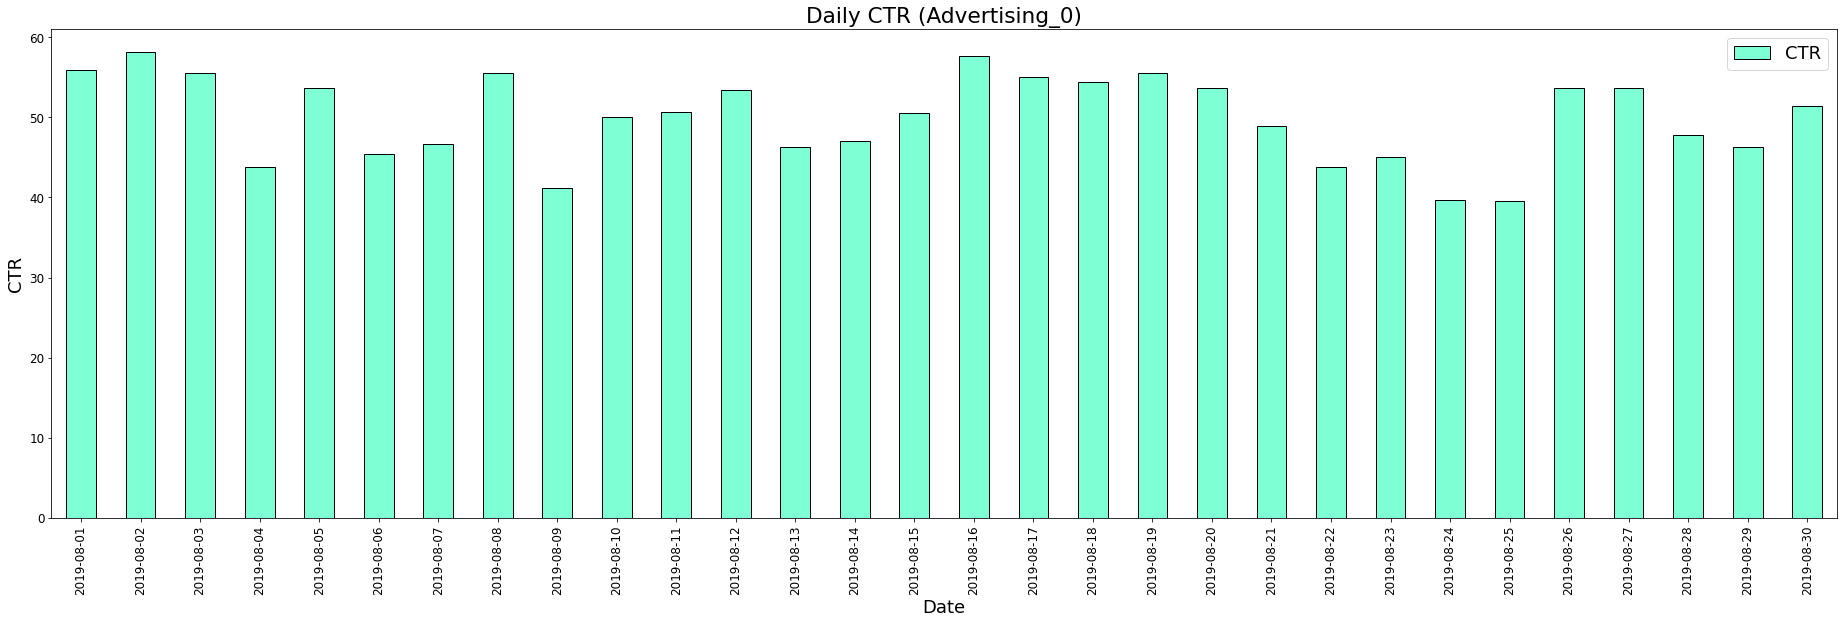

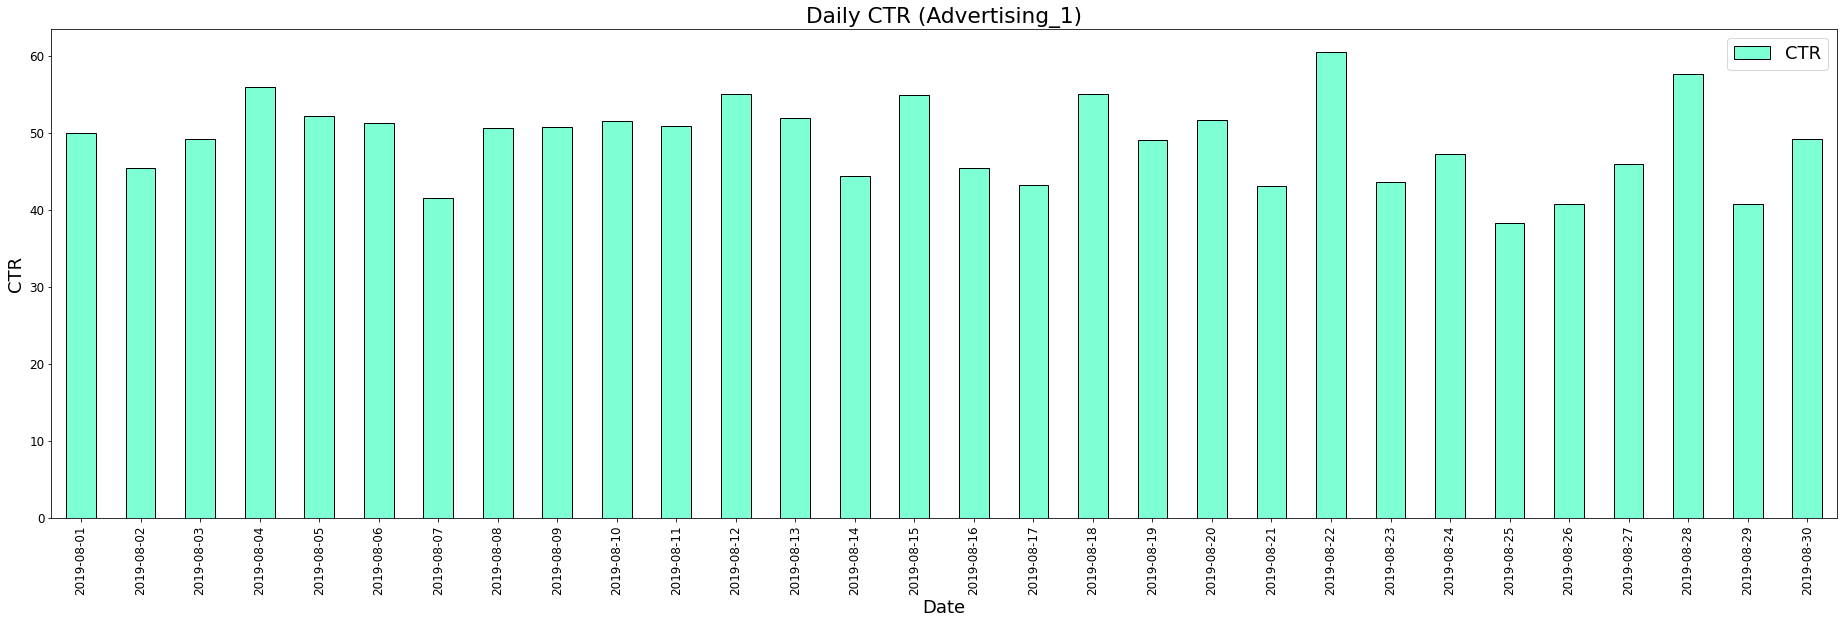

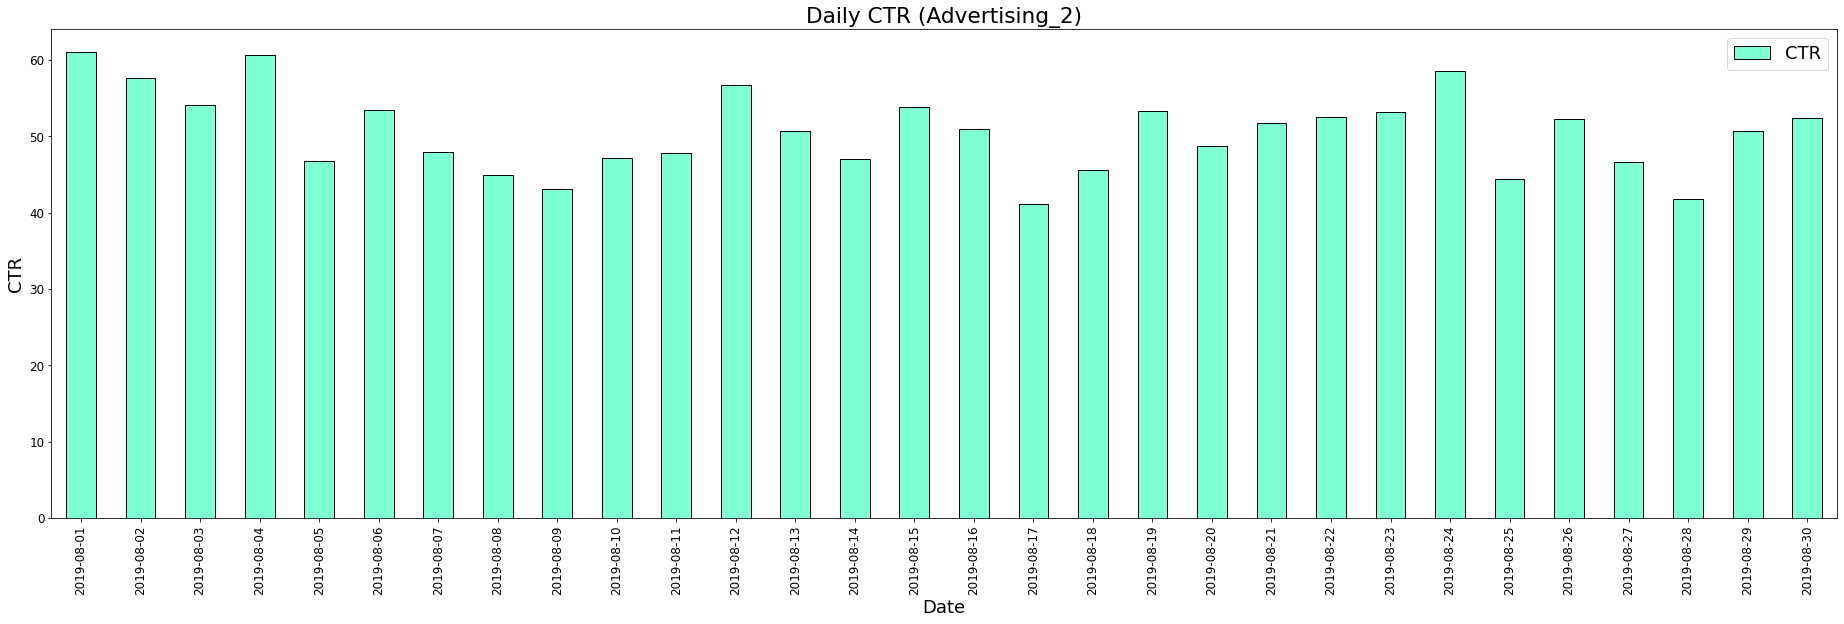

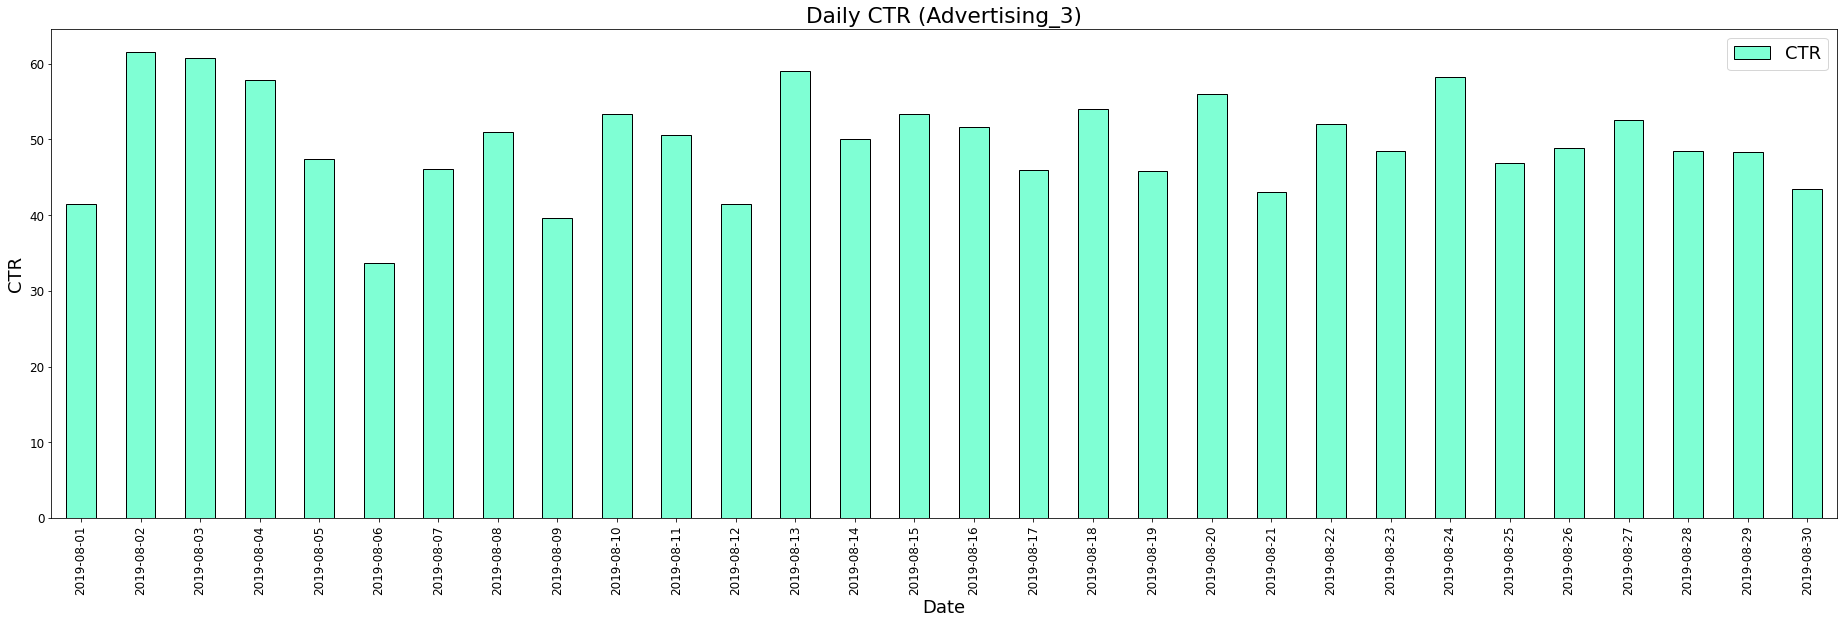

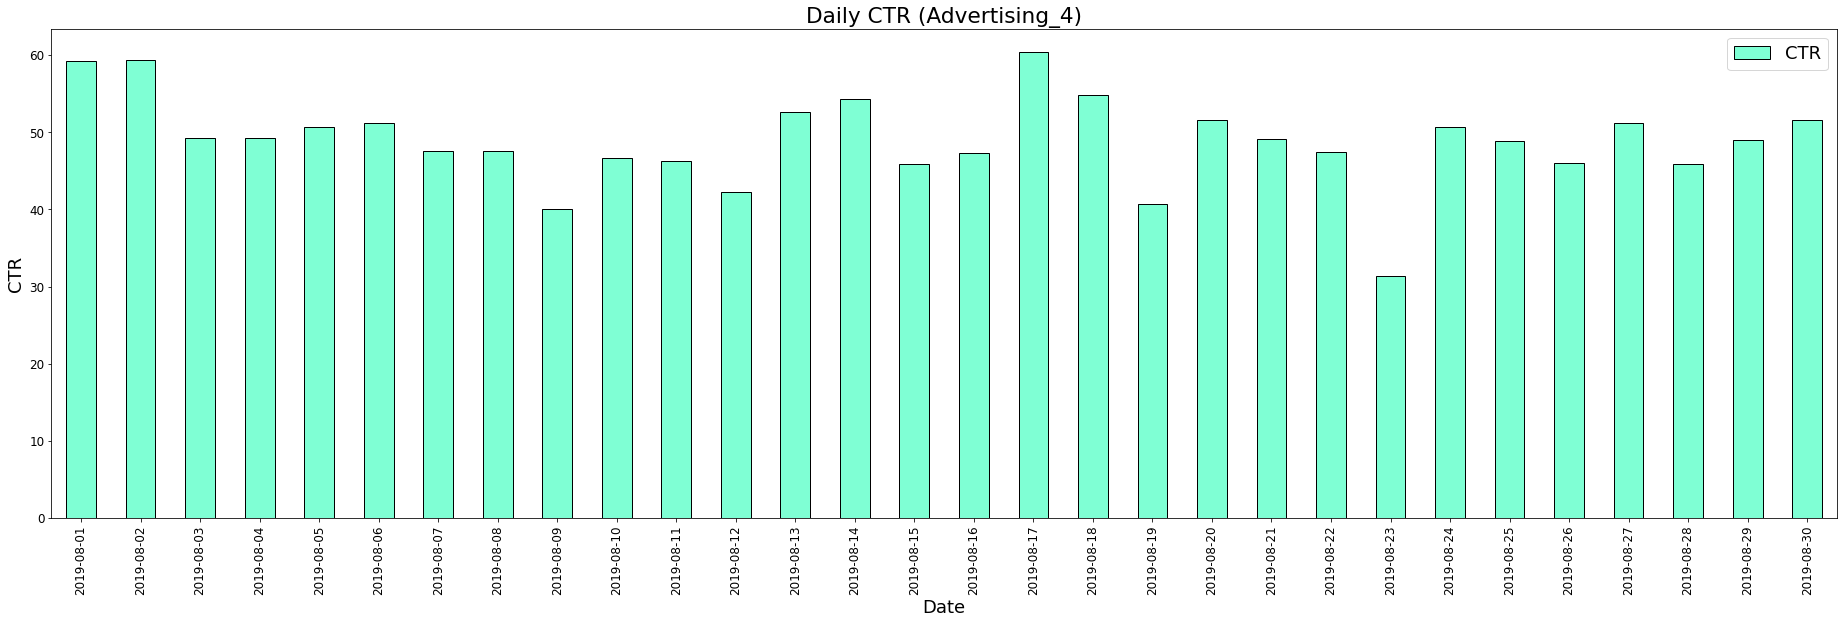

In [ ]:
plt.rcParams.update({'font.size': 18})
for adv in advertisings:
  data[data['name'] == adv].plot.bar(x="date", y="CTR", figsize=(32,9), fontsize=12, xlabel="Date", ylabel='CTR', title=f'Daily CTR ({adv})', color='aquamarine', edgecolor='black')

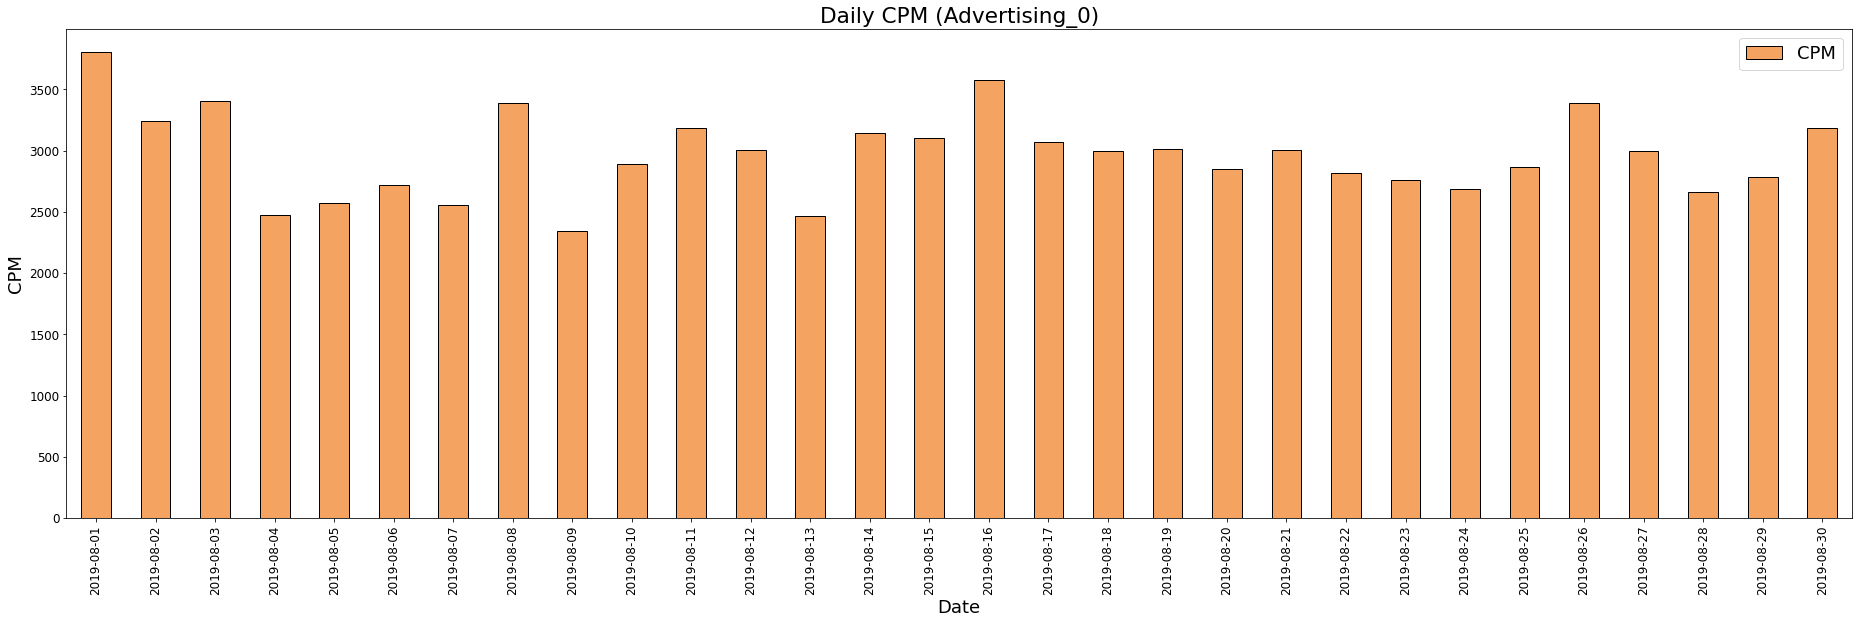

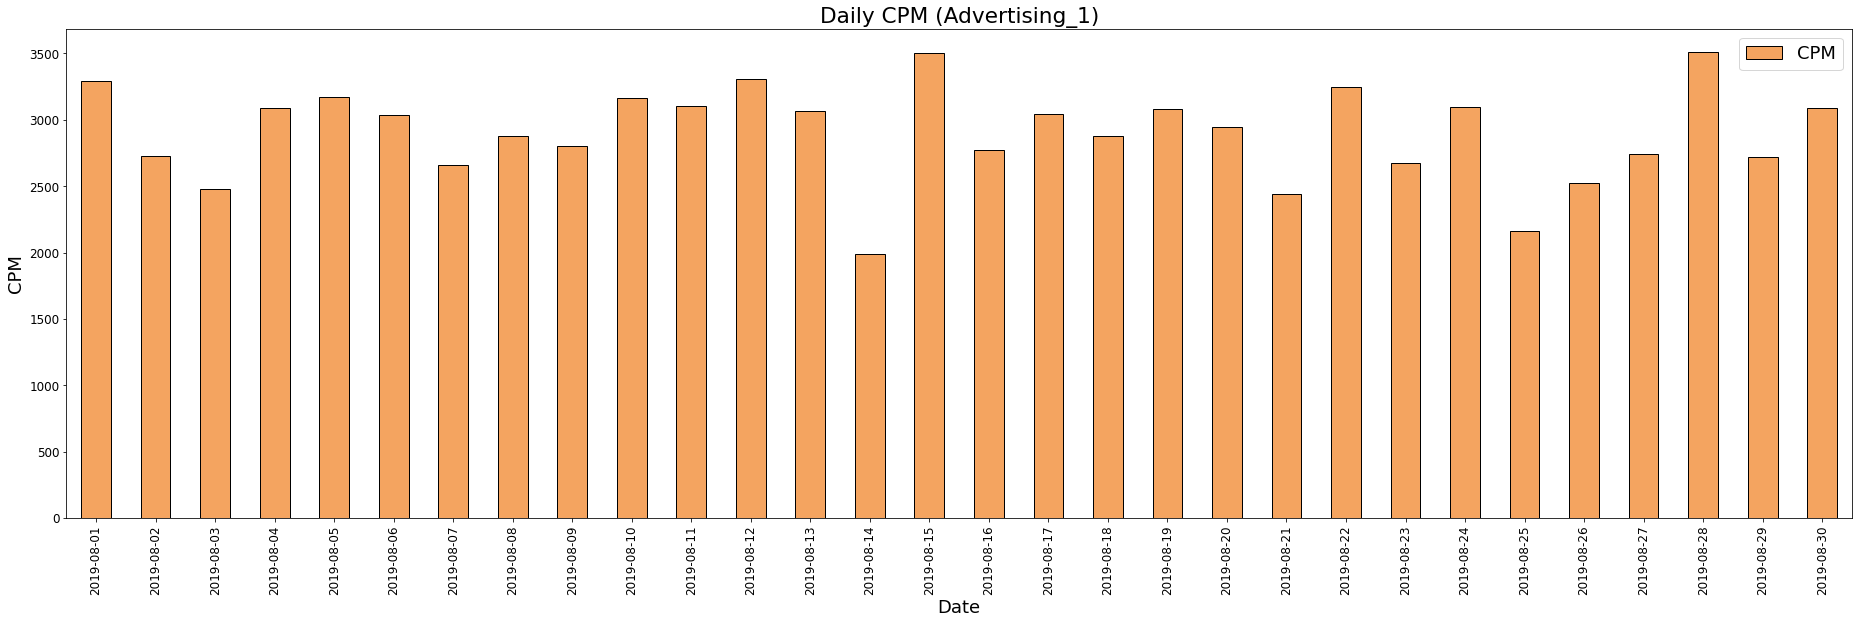

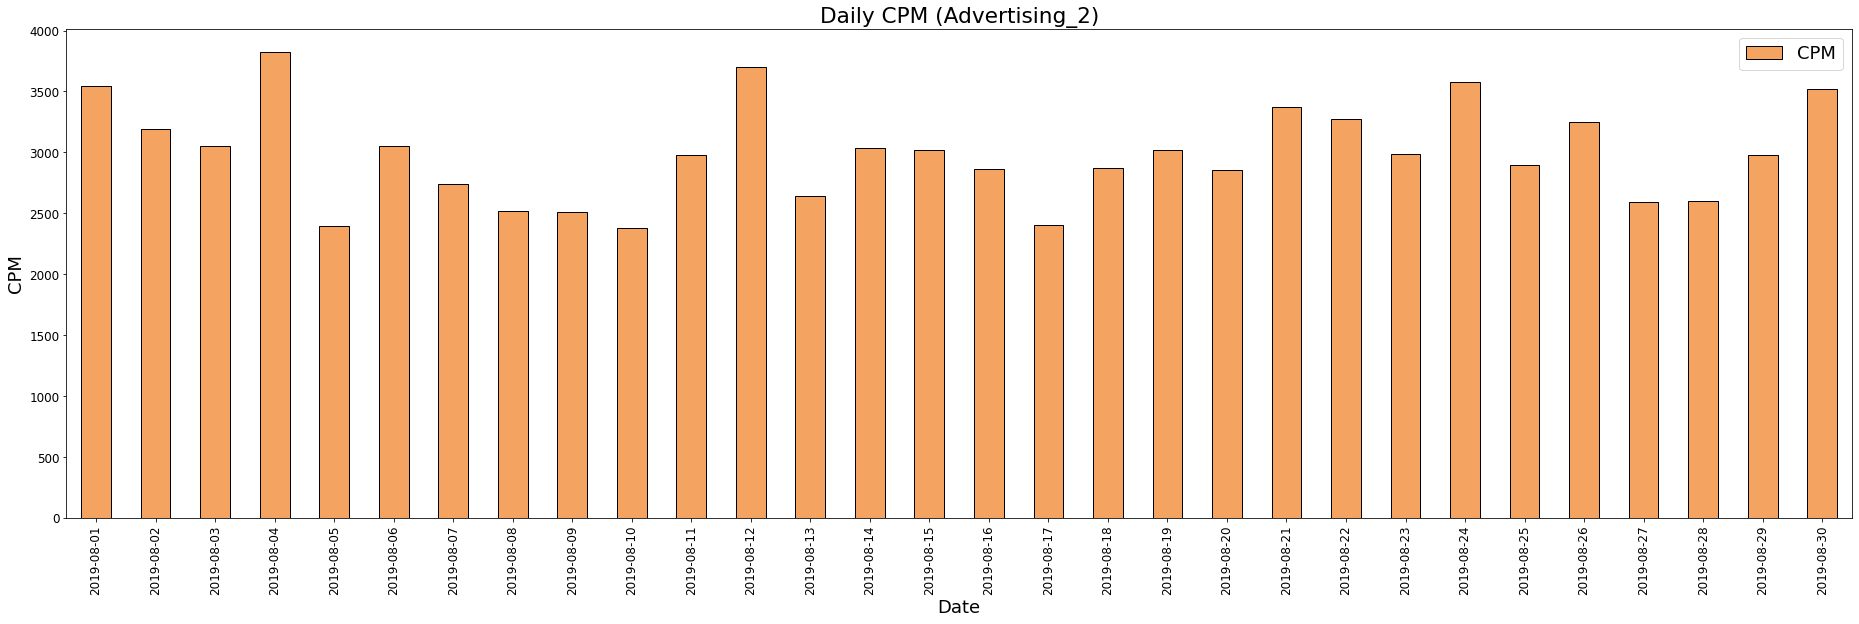

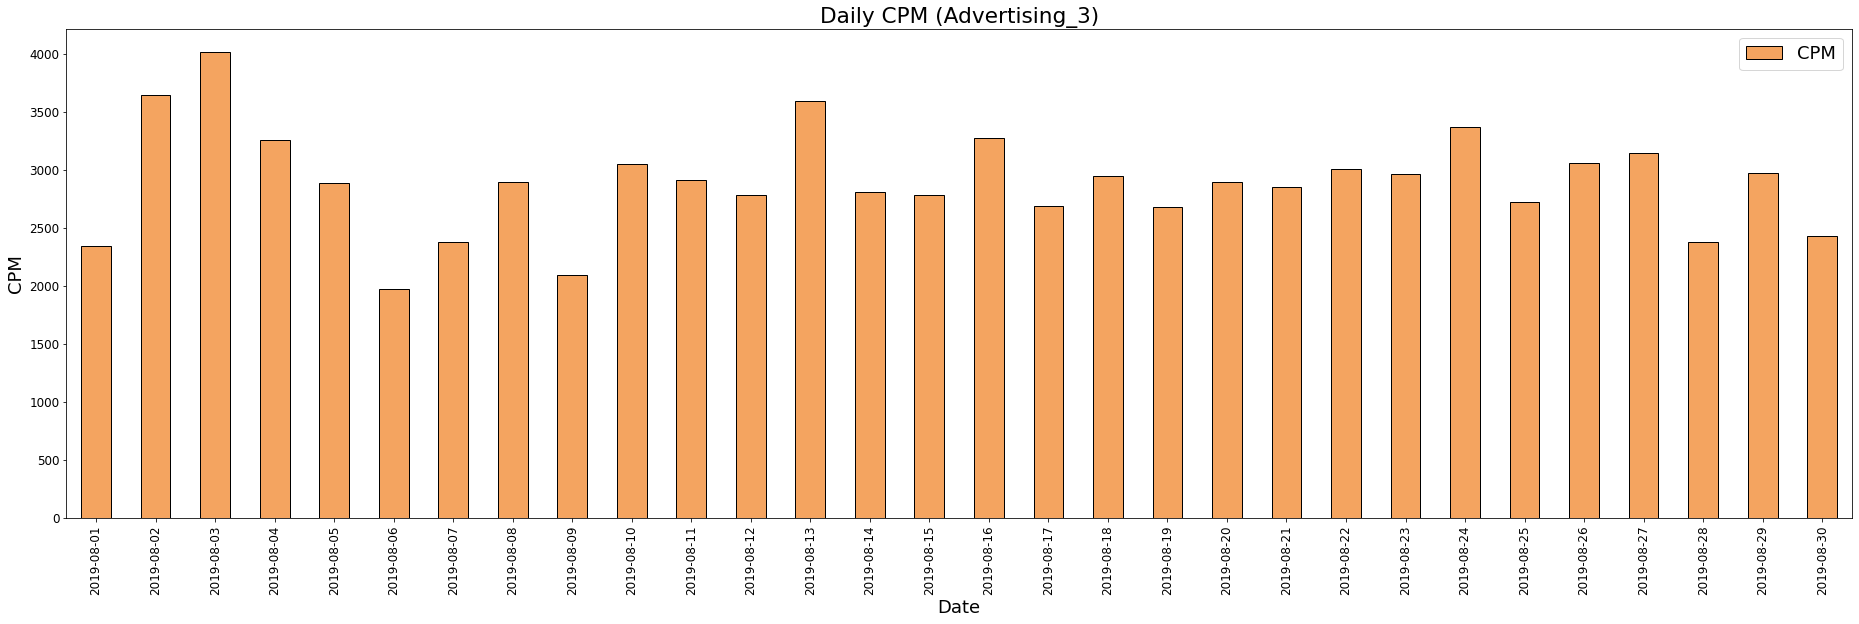

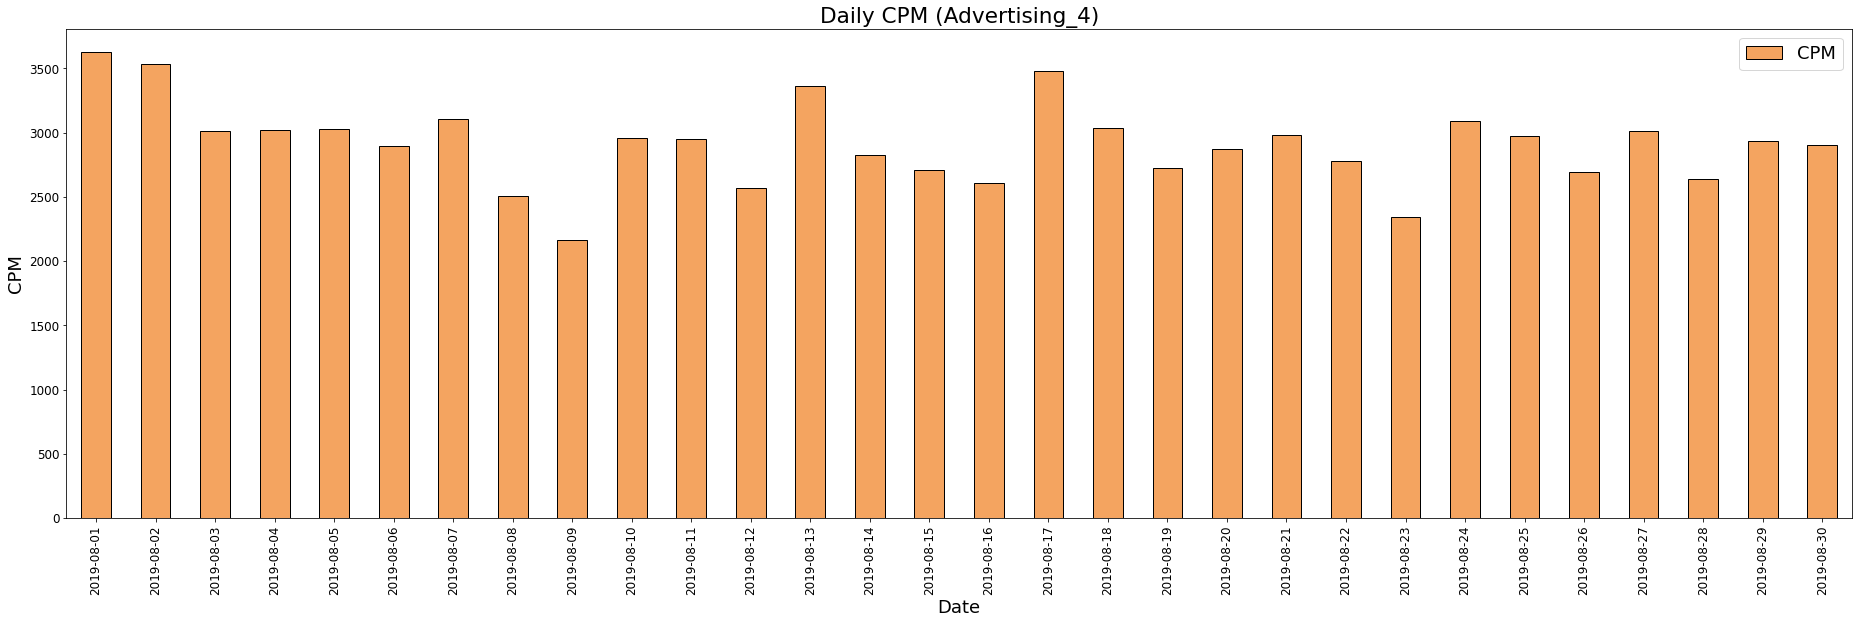

In [ ]:
plt.rcParams.update({'font.size': 18})
for adv in advertisings:
  data[data['name'] == adv].plot.bar(x="date", y="CPM", figsize=(32,9), fontsize=12, xlabel="Date", ylabel='CPM', title=f'Daily CPM ({adv})', color='sandybrown', edgecolor='black')